# HATE SPEECH DETECTION - Sentiment Analysis Project


Viggiano Martina (954603)

**TODO**:

- Learning curve Tfidf per capire best n° of features
- scrivere al prof per polarity+tfidf
- togliere bigram-trigrams
- suddividere il notebook in vari pezzi
- dashboard: https://streamlit.io/
- varie ed eventuali

## 1. Data import and error removal
Hate speech dataset from a white supremacist forum:  https://github.com/Vicomtech/hate-speech-dataset

In [1]:
!pip install unidecode clean-text[gpl] tweet-preprocessor streamlit

In [2]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm.notebook import tqdm
import ntpath
import matplotlib.pyplot as plt
import nltk
import nltk.sentiment.vader as vd
import string
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import download
from langdetect import detect
import spacy
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
    plot_precision_recall_curve,
    plot_roc_curve,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import preprocessor as pproc
from cleantext import clean

In [3]:
tqdm.pandas()

C:\Users\marti\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
nlp = spacy.load("en_core_web_sm")

## To load back the data df

This will load the serialized `data` DataFrame with all the modifications made, so that you can skip most of the code below where we actually compute data to assign to it. However, we still need to run the cells that compute the top nouns or top adj for example.

In [6]:
with open("data.pkl", "rb") as f:
    data = pickle.load(f)

In [7]:
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning,spacy_doc,POS_spacy,lemmatized,tokens,...,polarity_NPVAAA,polarity_ADJ,polarity_NOUN,polarity_PROPN,polarity_VERB,polarity_ADV,polarity_ADP,polarity_PRON,polarity_SCONJ,polarity_INTJ
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11,"(march, booklet, downloaded, times, counting)","[(march, PROPN), (booklet, PROPN), (downloaded...",march booklet download time count,"[march, booklet, downloaded, times, counting]",...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15,"(order, help, increase, booklets, downloads, w...","[(order, NOUN), (help, VERB), (increase, VERB)...",order help increase booklet download would gre...,"[order, help, increase, booklets, downloads, w...",...,0.400000,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6,"(simply, copy, paste, following, text, youtube...","[(simply, ADV), (copy, VERB), (paste, NOUN), (...",simply copy paste follow text youtube videos d...,"[simply, copy, paste, following, text, youtube...",...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10,"(click, free, download, colorfully, illustrate...","[(click, VERB), (free, ADJ), (download, NOUN),...",click free download colorfully illustrate page...,"[click, free, download, colorfully, illustrate...",...,0.233333,0.2,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8,"(click, download, megabytes, green, banner, link)","[(click, VERB), (download, PROPN), (megabytes,...",click download megabyte green banner link,"[click, download, megabytes, green, banner, link]",...,-0.200000,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load data from scratch

In [8]:
all_files_paths = glob.glob("hate-speech-dataset/all_files/*.txt")

In [9]:
all_files_paths = [f for f in all_files_paths if os.path.isfile(f)]

In [10]:
all_files_names = [str(ntpath.basename(f)).replace(".txt", "") for f in all_files_paths]

In [11]:
txt_content = {}
errors = []
for name, path in tqdm(list(zip(all_files_names, all_files_paths))):
    with open(path, "r") as txt:
        try:
            txt_content[name] = txt.readline().replace(",", "")
        except Exception as ex:
            errors.append((name, str(ex)))

In [12]:
errors

[('13491591_4',
  "'charmap' codec can't decode byte 0x81 in position 23: character maps to <undefined>"),
 ('13493456_1',
  "'charmap' codec can't decode byte 0x81 in position 169: character maps to <undefined>"),
 ('13500400_1',
  "'charmap' codec can't decode byte 0x81 in position 67: character maps to <undefined>"),
 ('13560796_1',
  "'charmap' codec can't decode byte 0x81 in position 5: character maps to <undefined>"),
 ('13572081_1',
  "'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>"),
 ('13588794_3',
  "'charmap' codec can't decode byte 0x81 in position 54: character maps to <undefined>"),
 ('13595072_1',
  "'charmap' codec can't decode byte 0x8d in position 75: character maps to <undefined>"),
 ('13595072_5',
  "'charmap' codec can't decode byte 0x8d in position 78: character maps to <undefined>"),
 ('14061724_1',
  "'charmap' codec can't decode byte 0x81 in position 181: character maps to <undefined>"),
 ('14065492_1',
  "'charmap' codec ca

In [13]:
errors_list = [err[0] for err in errors]

In [14]:
df = pd.DataFrame.from_dict(txt_content, orient='index').reset_index()
df.columns = ["file_id","text"]

In [15]:
df.head()

,file_id,text
0,12834217_1,As of March 13th 2014 the booklet had been d...
1,12834217_10,Thank you in advance. : ) Download the youtube...
2,12834217_2,In order to help increase the booklets downloa...
3,12834217_3,( Simply copy and paste the following text int...
4,12834217_4,Click below for a FREE download of a colorfull...


In [16]:
ann = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')

In [17]:
ann.head()

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


In [18]:
ann = ann[~ann['file_id'].isin(errors_list)]

In [19]:
data = pd.merge(left=ann, right=df, left_on='file_id', right_on='file_id')
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,As of March 13th 2014 the booklet had been d...
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


In [20]:
data['label'].unique()

array(['noHate', 'hate', 'idk/skip', 'relation'], dtype=object)

In [21]:
data = data.loc[(data["label"] != "relation") & (data["label"] != "idk/skip")]

In [22]:
data.drop(columns=["file_id", "user_id", "subforum_id", "num_contexts"], inplace=True)

In [23]:
data['label'] = data.apply(lambda x: 0 if x['label'] == "noHate" else 1, axis=1)

In [24]:
data.head()

,label,text
0,0,As of March 13th 2014 the booklet had been d...
1,0,In order to help increase the booklets downloa...
2,0,( Simply copy and paste the following text int...
3,1,Click below for a FREE download of a colorfull...
4,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


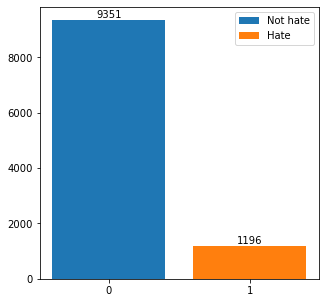

In [225]:
fig, ax = plt.subplots(figsize=(5,5))
labels = data["label"].value_counts().values
rects1 = ax.bar("0", data["label"].value_counts().values[0], label='Not hate')
rects2 = ax.bar("1", data["label"].value_counts().values[1], label='Hate')
rects = ax.patches
ax.legend()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

## 2. CLEANING

### 2.1 Removing links, tags, numbers and bias

In [26]:
cList = {
    "n't": " not",
    "/TD": " ",
    " PM ": " personal message ",
    " pm ": " personal message ",
    "PM ": "personal message ",
    " Donot ": " do not ",
    " MB ": " megabytes ",
}

c_re = re.compile("(%s)" % "|".join(cList.keys()))

In [27]:
def expand_contractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]

    return c_re.sub(replace, text)

In [28]:
data['text'] = data["text"].apply(lambda x: expand_contractions(x))

In [29]:
data['text'][3156]

"Classic trucker songs YouTube - & #x202a ; Dave Dudley - Diesel Smoke ( 18WoS : PTTM ) & #x202c ; & rlm ; Diesel Smoke another of same song  different video  says the artist was Red Simpson YouTube - & #x202a ; Red Simpson - Diesel smoke  & #x202c ; & rlm ; YouTube - & #x202a ; Red Sovine-Truck Drivin ' Son Of A Gun & #x202c ; & rlm ; Truck Drivin ' Son of a Gun YouTube - & #x202a ; Terry Allen - Amarillo Highway & #x202c ; & rlm ; Amarillo Highway ( slow version  live  with violins ) YouTube - & #x202a ; Robert Earl Keen - Amarillo Highway & #x202c ; & rlm ; Fast rockin ' country version by Robert Earl Keene"

In [30]:
pproc.clean("ciao prova stringa")

'ciao prova stringa'

In [31]:
data["text_clean"] = data["text"].apply(
    lambda x: pproc.clean(
        clean(
            pproc.clean(x),
            fix_unicode=True,  # fix various unicode errors
            to_ascii=True,  # transliterate to closest ASCII representation
            lower=True,  # lowercase text
            no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
            no_urls=True,  # replace all URLs with a special token
            no_emails=True,  # replace all email addresses with a special token
            no_phone_numbers=True,  # replace all phone numbers with a special token
            no_numbers=True,  # replace all numbers with a special token
            no_digits=True,  # replace all digits with a special token
            no_currency_symbols=True,  # replace all currency symbols with a special token
            no_punct=True,
        )
    )
)

In [32]:
swords = set().union(stopwords.words("english"), string.punctuation)

data["text_clean"] = (
    data["text_clean"]
    .str.lower()
    .str.replace(r"(@[a-z0-9]+)\w+", " ")
    .str.replace(r"http\S+", "")
    .str.replace(r"www\S+", " ")
    .str.replace(r"com/watch", " ")
    .str.replace(r"\S*[.,:;!?-]\S*[^\s\.,:;!?-]", " ")
    .str.replace(r" th ", " ")
    .str.replace(r" th ", " ")
    .str.replace(r"\w*\d\w*", " ")
    .str.replace(r"rlm", " ")
    .str.replace(r"pttm", " ")
    .str.replace(r"ghlight", " ")
    .str.replace(r"[0-9]+(?:st| st|nd| nd|rd| rd|th| th)", "")
    .str.replace(r"([^a-z \t])", " ")
    .str.replace(r" +", " ")
    .apply(lambda x: " ".join([i for i in x.split() if not i in swords]))
)

In [33]:
def full_text_clean(text):
    cList = {
        "n't": " not",
        "/TD": " ",
        " PM ": " personal message ",
        " pm ": " personal message ",
        "PM ": "personal message ",
        " Donot ": " do not ",
        " MB ": " megabytes ",
    }

    c_re = re.compile("(%s)" % "|".join(cList.keys()))
    
    def expand_contractions(text, c_re=c_re):
        def replace(match):
            return cList[match.group(0)]

        return c_re.sub(replace, text)
    
    qualcosa = expand_contractions(text)
    
    qualcosaltro = pproc.clean(
            clean(
                pproc.clean(qualcosa),
                fix_unicode=True,  # fix various unicode errors
                to_ascii=True,  # transliterate to closest ASCII representation
                lower=True,  # lowercase text
                no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
                no_urls=True,  # replace all URLs with a special token
                no_emails=True,  # replace all email addresses with a special token
                no_phone_numbers=True,  # replace all phone numbers with a special token
                no_numbers=True,  # replace all numbers with a special token
                no_digits=True,  # replace all digits with a special token
                no_currency_symbols=True,  # replace all currency symbols with a special token
                no_punct=True,
            )
        )
    
    swords = set().union(stopwords.words("english"), string.punctuation)

    altroancora = (
        qualcosaltro
        .lower()
        .replace(r"(@[a-z0-9]+)\w+", " ")
        .replace(r"http\S+", "")
        .replace(r"www\S+", " ")
        .replace(r"com/watch", " ")
        .replace(r"\S*[.,:;!?-]\S*[^\s\.,:;!?-]", " ")
        .replace(r" th ", " ")
        .replace(r" th ", " ")
        .replace(r"\w*\d\w*", " ")
        .replace(r"rlm", " ")
        .replace(r"pttm", " ")
        .replace(r"ghlight", " ")
        .replace(r"[0-9]+(?:st| st|nd| nd|rd| rd|th| th)", "")
        .replace(r"([^a-z \t])", " ")
        .replace(r" +", " ")
        )
    
    altroancora = " ".join([i for i in altroancora.split() if not i in swords])
    
    return altroancora

In [34]:
data.head()

,label,text,text_clean
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link


In [35]:
data['text_clean'][3156]

'classic trucker songs youtube dave dudley diesel smoke wos diesel smoke another song different video says artist red simpson youtube red simpson diesel smoke youtube red sovinetruck drivin son gun truck drivin son gun youtube terry allen amarillo highway amarillo highway slow version live violins youtube robert earl keen amarillo highway fast rockin country version robert earl keene'

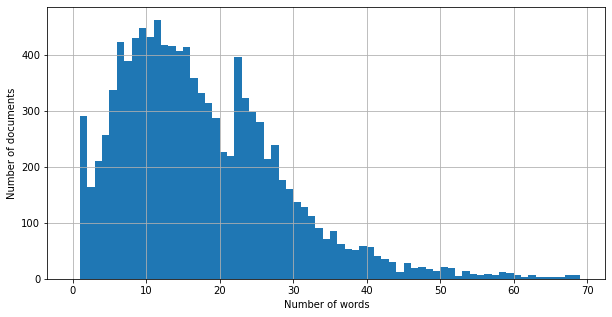

In [36]:
data['word_count_before'] = data['text'].apply(lambda x: len(x.split())) # Number of words in the string
plt.figure(figsize=(10,5))
plt.hist(data.word_count_before.values, bins = range(0, 70))
plt.xlabel("Number of words")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()

In [37]:
data['word_count'] = data['text_clean'].apply(lambda x: len(x.split()))

In [38]:
data['word_cleaning'] = data['word_count_before'] - data['word_count']
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8


In [39]:
data[['word_count_before','word_count','word_cleaning']].describe()

,word_count_before,word_count,word_cleaning
count,10694.000000,10694.000000,10694.000000
mean,17.643632,8.181597,9.462035
std,13.336809,6.684814,7.419962
min,1.000000,0.000000,0.000000
25%,9.000000,4.000000,5.000000
50%,15.000000,7.000000,8.000000
75%,24.000000,11.000000,13.000000
max,343.000000,141.000000,202.000000


In [40]:
data = data.loc[data['word_count'] > 0, ]

In [41]:
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8


### 2.2 Lemmatizer and Tokenization

In [42]:
data['spacy_doc'] = data['text_clean'].progress_apply(lambda x: nlp(x))

In [43]:
# Parallel
docs = nlp.pipe(data['text_clean'], n_process=2, batch_size=2000)

In [44]:
a = [x for x in tqdm(docs)]

In [45]:
for x in data.spacy_doc[0]:
    print(x.text, x.pos_, x.lemma_, x.lang_)

march PROPN march en
booklet PROPN booklet en
downloaded VERB download en
times NOUN time en
counting VERB count en


In [46]:
data['POS_spacy'] = data['spacy_doc'].progress_apply(lambda x: [(y.text, y.pos_) for y in x])

In [47]:
data['lemmatized'] = data['spacy_doc'].progress_apply(lambda x: " ".join([y.lemma_ for y in x]))

In [48]:
data['tokens'] = data['spacy_doc'].progress_apply(lambda x: [y.text for y in x])

In [49]:
data['language'] = data['spacy_doc'].progress_apply(lambda x: set([y.lang_ for y in x]))

In [50]:
length = {}
for line in data['language']:
    if len(line) in length:
        length[len(line)] += 1
    else:
        length[len(line)] = 1
length

{1: 10547}

In [51]:
data['language'] = data['language'].progress_apply(lambda x: list(x)[0])

In [52]:
data['language'].unique()

array(['en'], dtype=object)

In [53]:
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning,spacy_doc,POS_spacy,lemmatized,tokens,language
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11,"(march, booklet, downloaded, times, counting)","[(march, PROPN), (booklet, PROPN), (downloaded...",march booklet download time count,"[march, booklet, downloaded, times, counting]",en
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15,"(order, help, increase, booklets, downloads, w...","[(order, NOUN), (help, VERB), (increase, VERB)...",order help increase booklet download would gre...,"[order, help, increase, booklets, downloads, w...",en
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6,"(simply, copy, paste, following, text, youtube...","[(simply, ADV), (copy, VERB), (paste, NOUN), (...",simply copy paste follow text youtube videos d...,"[simply, copy, paste, following, text, youtube...",en
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10,"(click, free, download, colorfully, illustrate...","[(click, VERB), (free, ADJ), (download, NOUN),...",click free download colorfully illustrate page...,"[click, free, download, colorfully, illustrate...",en
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8,"(click, download, megabytes, green, banner, link)","[(click, VERB), (download, PROPN), (megabytes,...",click download megabyte green banner link,"[click, download, megabytes, green, banner, link]",en


### 2.4 Bow and Tfidf

In [54]:
# Bow vectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['lemmatized'])
#print(bow_vectorizer.get_feature_names())

In [55]:
# Tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])
#print(tfidf_vectorizer.get_feature_names())

In [56]:
Xa = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
dictionary = ['white', 'black', 'kill', 'kid', 'school','student']
A = Xa[dictionary]
A[10:25]

,white,black,kill,kid,school,student
10,0.121065,0.154474,0.215416,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.301538,0.000000,0.000000,0.000000,0.000000,0.000000
18,0.150519,0.000000,0.000000,0.000000,0.000000,0.000000
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [57]:
#pd.DataFrame(X_tfidf[20:50, 58:70].toarray(), columns=list(tfidf_vectorizer.vocabulary_.keys())[58:70])

## 3. TOP WORDS

In [58]:
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [59]:
common_words = get_top_n_words(data['lemmatized'], 50)
cmw = {word: freq for word, freq in common_words}

In [60]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]
mcw[:20] # Most common words between lemmatized words and frequencies

,words,freq
0,white,1430
1,get,801
2,like,796
3,go,699
4,people,614
5,see,606
6,pron,605
7,black,582
8,one,550
9,would,517


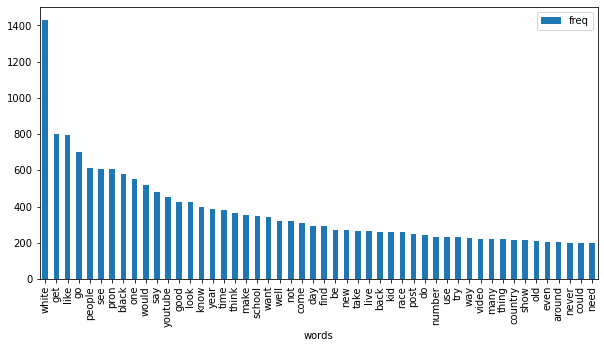

In [61]:
mcw.plot(x="words", y="freq", kind="bar", figsize=(10,5))
plt.show()

### 3.1 Part of speech (POS)

In [62]:
all_pos = data['POS_spacy'].sum()

In [63]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]

In [64]:
hate = data.loc[data["label"] == 1]

In [65]:
all_pos_hate = hate['POS_spacy'].sum()

In [66]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]

### 3.2 Top Adjectives

In [67]:
adj_counter = {}
for word in all_adjs:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1

top_20_adj = {k: v for k, v in sorted(adj_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj, orient="index", columns=["Freq"]).reset_index()

In [68]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
top_20_adj1 = {k: v for k, v in sorted(adj_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj1, orient="index", columns=["Freq"]).reset_index()

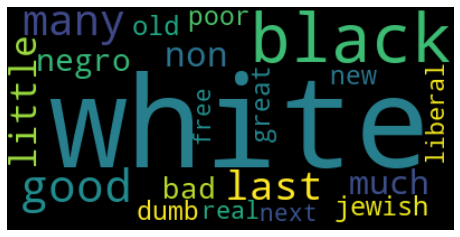

In [69]:
from wordcloud import WordCloud
wc_a_hate = WordCloud().generate_from_frequencies(top_20_adj1)
plt.figure(figsize=(8,5))
plt.imshow(wc_a_hate, interpolation="bilinear")
plt.axis("off")
plt.show()

In [70]:
top_adj = {"Total": top_20_adj.keys(), "Freq_Total": top_20_adj.values(), "Hate_Speech": top_20_adj1.keys(), "Freq_Hate": top_20_adj1.values()}
top_adj = pd.DataFrame(top_adj)
top_adj["R_Freq_Total"] = top_adj.apply(lambda x: np.round(x.Freq_Total / top_adj.Freq_Total.sum(), 3), axis=1)
top_adj["R_Freq_Hate"] = top_adj.apply(lambda x: np.round(x.Freq_Hate / top_adj.Freq_Hate.sum(), 3), axis=1)
top_adj = top_adj.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_adj

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.238,white,0.274
1,good,0.101,black,0.167
2,black,0.097,good,0.063
3,many,0.067,many,0.055
4,new,0.056,last,0.049
5,old,0.055,little,0.041
6,last,0.048,non,0.036
7,great,0.045,much,0.034
8,little,0.034,negro,0.032
9,much,0.032,bad,0.028


In [71]:
common_adj = list(set(top_adj["Hate_Speech"].values).union(set(top_adj["Total"].values)))

In [72]:
freq_common_tot_adj = [adj_counter[x] for x in common_adj]
freq_common_hate_adj = [adj_counter1[x] for x in common_adj]

In [73]:
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq_Tot": freq_common_tot_adj, "Freq_Hate_Speech": freq_common_hate_adj })

In [74]:
common_adj_df

,Adj,Freq_Tot,Freq_Hate_Speech
0,high,67,7
1,real,56,13
2,black,324,103
3,little,114,25
4,different,69,10
5,first,66,3
6,next,74,12
7,non,58,22
8,poor,36,14
9,much,107,21


In [75]:
common_adj_df.sort_values(by=["Freq_Hate_Speech"], ascending=False, inplace=True)

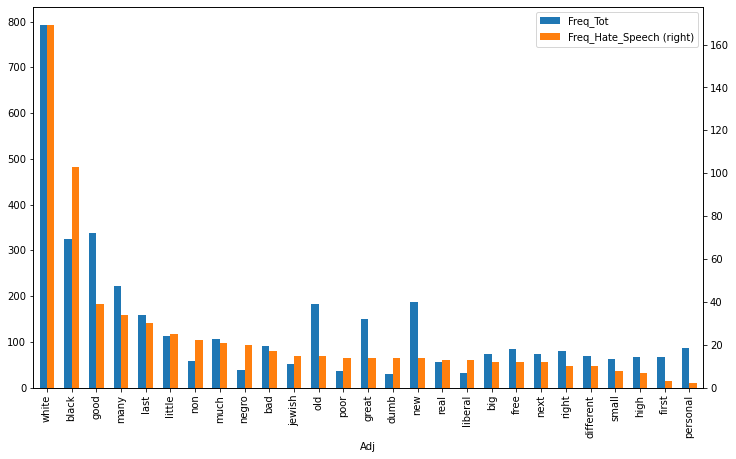

In [76]:
common_adj_df.set_index("Adj").plot(secondary_y=['Freq_Hate_Speech'], kind='bar', figsize=(12,7), width=0.6)

plt.show()

### 3.3 Top Nouns

In [77]:
noun_counter = {}
for word in all_nouns:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
top_20_noun = {k: v for k, v in sorted(noun_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun, orient="index", columns=["Freq"]).reset_index()

In [78]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
top_20_noun1 = {k: v for k, v in sorted(noun_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun1, orient="index", columns=["Freq"]).reset_index()

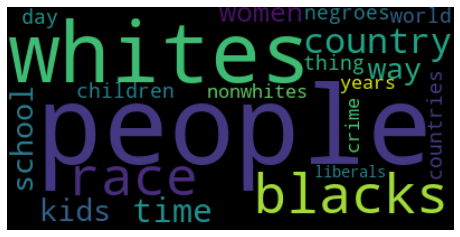

In [79]:
wc_n_hate = WordCloud().generate_from_frequencies(top_20_noun1)
plt.figure(figsize=(8,5))
plt.imshow(wc_n_hate, interpolation="bilinear")
plt.axis("off")
plt.show()

In [80]:
top_noun = {"Total": top_20_noun.keys(), "Freq_Total": top_20_noun.values(), "Hate_Speech": top_20_noun1.keys(), "Freq_Hate": top_20_noun1.values()}
top_noun = pd.DataFrame(top_noun)
top_noun["R_Freq_Total"] = top_noun.apply(lambda x: np.round(x.Freq_Total / top_noun.Freq_Total.sum(), 3), axis=1)
top_noun["R_Freq_Hate"] = top_noun.apply(lambda x: np.round(x.Freq_Hate / top_noun.Freq_Hate.sum(), 3), axis=1)
top_noun = top_noun.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_noun

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,people,0.156,people,0.131
1,time,0.068,whites,0.121
2,whites,0.067,blacks,0.096
3,school,0.054,race,0.090
4,race,0.054,country,0.059
5,number,0.053,time,0.051
6,years,0.052,way,0.041
7,kids,0.051,kids,0.039
8,year,0.047,school,0.039
9,blacks,0.046,women,0.037


In [81]:
common_nouns = list(set(top_noun["Hate_Speech"].values).union(set(top_noun["Total"].values)))

In [82]:
freq_common_noun_tot = [noun_counter[x] for x in common_nouns]
freq_common_noun_hate = [noun_counter1[x] for x in common_nouns]

In [83]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq_Tot": freq_common_noun_tot, "Freq_Hate_Speech": freq_common_noun_hate })

In [84]:
common_noun_df.sort_values(by=["Freq_Hate_Speech"], ascending=False, inplace=True)

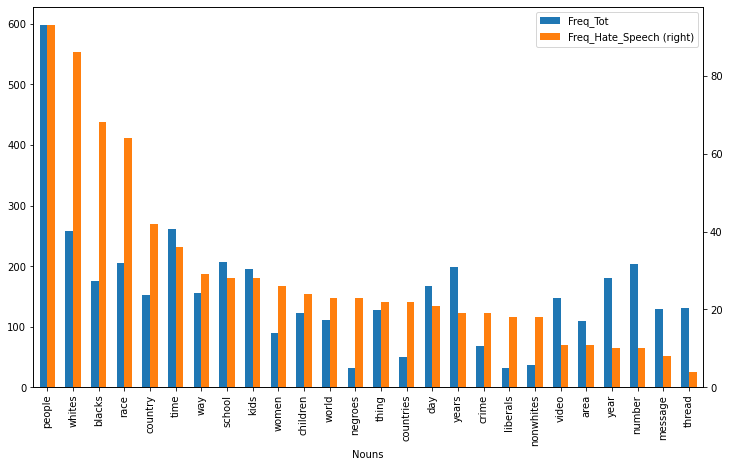

In [85]:
common_noun_df.set_index("Nouns").plot(secondary_y=['Freq_Hate_Speech'], kind='bar', figsize=(12,7), width=0.6)

plt.show()

### 3.2 Top Proper Noun

In [86]:
all_propn = [x[0] for x in all_pos if x[1] == "PROPN"]
all_propn_hate = [x[0] for x in all_pos_hate if x[1] == "PROPN"]

In [87]:
propn_counter = {}
for word in all_propn:
    if word in propn_counter:
        propn_counter[word] += 1
    else:
        propn_counter[word] = 1

top_20_propn = {k: v for k, v in sorted(propn_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_propn, orient="index", columns=["Freq"]).reset_index()

In [88]:
propn_counter1 = {}
for word in all_propn_hate:
    if word in propn_counter1:
        propn_counter1[word] += 1
    else:
        propn_counter1[word] = 1
            
top_20_propn1 = {k: v for k, v in sorted(propn_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_propn1, orient="index", columns=["Freq"]).reset_index()

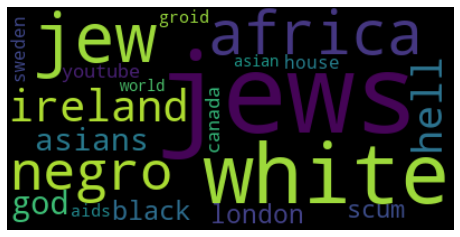

In [89]:
wc_p_hate = WordCloud().generate_from_frequencies(top_20_propn1)
plt.figure(figsize=(8,5))
plt.imshow(wc_p_hate, interpolation="bilinear")
plt.axis("off")
plt.show()

In [90]:
top_propn = {"Total": top_20_propn.keys(), "Freq_Total": top_20_propn.values(), "Hate_Speech": top_20_propn1.keys(), "Freq_Hate": top_20_propn1.values()}
top_propn = pd.DataFrame(top_propn)
top_propn["R_Freq_Total"] = top_propn.apply(lambda x: np.round(x.Freq_Total / top_propn.Freq_Total.sum(), 3), axis=1)
top_propn["R_Freq_Hate"] = top_propn.apply(lambda x: np.round(x.Freq_Hate / top_propn.Freq_Hate.sum(), 3), axis=1)
top_propn = top_propn.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_propn

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.176,jews,0.148
1,youtube,0.172,white,0.142
2,jews,0.064,jew,0.092
3,ireland,0.060,africa,0.072
4,god,0.042,negro,0.059
5,jew,0.042,ireland,0.055
6,new,0.039,hell,0.050
7,africa,0.037,god,0.046
8,news,0.035,asians,0.044
9,black,0.035,black,0.033


In [91]:
common_propn = list(set(top_propn["Hate_Speech"].values).union(set(top_propn["Total"].values)))

In [92]:
freq_common_propn_tot = [propn_counter[x] for x in common_propn]
freq_common_propn_hate = [propn_counter1[x] for x in common_propn]

In [93]:
common_propn_df = pd.DataFrame({"Proper Nouns" : common_propn, "Freq_Tot": freq_common_propn_tot, "Freq_Hate_Speech": freq_common_propn_hate })

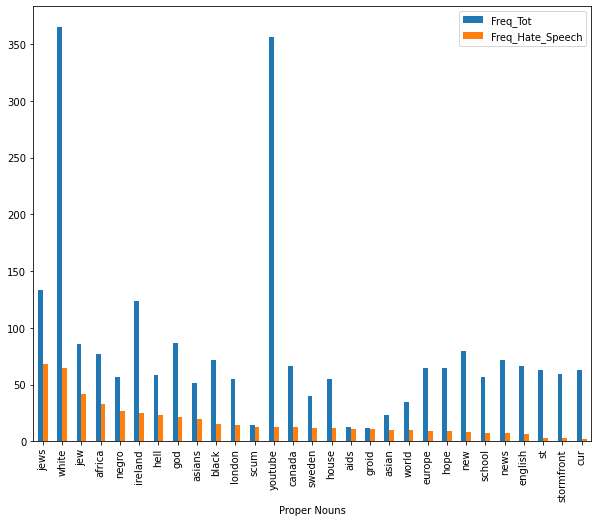

In [94]:
common_propn_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)
common_propn_df.plot('Proper Nouns', y=['Freq_Tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

### 3.4 Top POS

In [95]:
pos_counter = {}
for x in all_pos:
    if x[1] in pos_counter:
        pos_counter[x[1]] += 1
    else:
        pos_counter[x[1]] = 1
        
top_pos = {k: v for k, v in sorted(pos_counter.items(), key=lambda item: item[1], reverse=True)}

In [96]:
freq_pos = pd.DataFrame.from_dict(top_pos, orient="index", columns=["Freq"]).reset_index()
freq_pos["R_Freq"] = freq_pos.apply(lambda x: np.round(x.Freq / freq_pos.Freq.sum(), 2), axis=1)

In [97]:
pos_counter_hate = {}
for x in all_pos_hate:
    if x[1] in pos_counter_hate:
        pos_counter_hate[x[1]] += 1
    else:
        pos_counter_hate[x[1]] = 1
        
top_pos_hate = {k: v for k, v in sorted(pos_counter_hate.items(), key=lambda item: item[1], reverse=True)}

In [98]:
freq_pos_hate = pd.DataFrame.from_dict(top_pos_hate, orient="index", columns=["Freq"]).reset_index()
freq_pos_hate["R_Freq"] = freq_pos_hate.apply(lambda x: np.round(x.Freq / freq_pos_hate.Freq.sum(), 2), axis=1)

In [99]:
top_pos

{'NOUN': 27739,
 'VERB': 19574,
 'PROPN': 17692,
 'ADJ': 11413,
 'ADV': 5222,
 'PRON': 1517,
 'INTJ': 1012,
 'SCONJ': 979,
 'NUM': 817,
 'ADP': 737,
 'AUX': 515,
 'DET': 425,
 'PART': 364,
 'X': 177,
 'CCONJ': 108,
 'PUNCT': 30,
 'SYM': 9}

In [100]:
compared_pos = {"Total": list(top_pos.keys())[:len(top_pos_hate)], "Freq_Total": list(top_pos.values())[:len(top_pos_hate)], "Hate_Speech": top_pos_hate.keys(), "Freq_Hate": top_pos_hate.values()}
compared_pos = pd.DataFrame(compared_pos)
compared_pos["R_Freq_Total"] = compared_pos.apply(lambda x: np.round(x.Freq_Total / compared_pos.Freq_Total.sum(), 3), axis=1)
compared_pos["R_Freq_Hate"] = compared_pos.apply(lambda x: np.round(x.Freq_Hate / compared_pos.Freq_Hate.sum(), 3), axis=1)
compared_pos = compared_pos.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
compared_pos

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,NOUN,0.314,NOUN,0.322
1,VERB,0.222,VERB,0.237
2,PROPN,0.200,PROPN,0.172
3,ADJ,0.129,ADJ,0.141
4,ADV,0.059,ADV,0.061
5,PRON,0.017,PRON,0.016
6,INTJ,0.011,SCONJ,0.012
7,SCONJ,0.011,INTJ,0.008
8,NUM,0.009,NUM,0.007
9,ADP,0.008,ADP,0.007


In [101]:
def filter_text_pos(x):
    final_pos_text = []
    for elem in x:
        for pos in pos_list:
            if elem[1] == pos:
                final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

In [102]:
pos_list = ["NOUN"]
data["NOUN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['NOUN_count'] = data['NOUN'].apply(lambda x: len(x.split()))

In [103]:
pos_list = ["PROPN"]
data["PROPN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['PROPN_count'] = data['PROPN'].apply(lambda x: len(x.split()))

In [104]:
pos_list = ["VERB"]
data["VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['VERB_count'] = data['VERB'].apply(lambda x: len(x.split()))

In [105]:
pos_list = ["ADJ"]
data["ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['ADJ_count'] = data['ADJ'].apply(lambda x: len(x.split()))

In [106]:
pos_list = ["ADV"]
data["ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['ADV_count'] = data['ADV'].apply(lambda x: len(x.split()))

In [107]:
pos_list = ["PRON"]
data["PRON"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['PRON_count'] = data['PRON'].apply(lambda x: len(x.split()))

In [108]:
pos_list = ["SCONJ"]
data["SCONJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['SCONJ_count'] = data['SCONJ'].apply(lambda x: len(x.split()))

In [109]:
pos_list = ["INTJ"]
data["INTJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['INTJ_count'] = data['SCONJ'].apply(lambda x: len(x.split()))

In [110]:
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning,spacy_doc,POS_spacy,lemmatized,tokens,...,ADJ,ADJ_count,ADV,ADV_count,PRON,PRON_count,SCONJ,SCONJ_count,INTJ,INTJ_count
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11,"(march, booklet, downloaded, times, counting)","[(march, PROPN), (booklet, PROPN), (downloaded...",march booklet download time count,"[march, booklet, downloaded, times, counting]",...,,0,,0,,0,,0,,0
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15,"(order, help, increase, booklets, downloads, w...","[(order, NOUN), (help, VERB), (increase, VERB)...",order help increase booklet download would gre...,"[order, help, increase, booklets, downloads, w...",...,great youtube,2,,0,,0,,0,,0
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6,"(simply, copy, paste, following, text, youtube...","[(simply, ADV), (copy, VERB), (paste, NOUN), (...",simply copy paste follow text youtube videos d...,"[simply, copy, paste, following, text, youtube...",...,,0,simply,1,,0,,0,,0
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10,"(click, free, download, colorfully, illustrate...","[(click, VERB), (free, ADJ), (download, NOUN),...",click free download colorfully illustrate page...,"[click, free, download, colorfully, illustrate...",...,free intentional western,3,colorfully,1,,0,,0,,0
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8,"(click, download, megabytes, green, banner, link)","[(click, VERB), (download, PROPN), (megabytes,...",click download megabyte green banner link,"[click, download, megabytes, green, banner, link]",...,green,1,,0,,0,,0,,0


## 4. FEATURE SELECTION

In [111]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X_feature = data.loc[:, ["word_count_before","word_count", "word_cleaning", "NOUN_count", "PROPN_count", "VERB_count", "ADJ_count", "ADV_count", "PRON_count", "SCONJ_count", "INTJ_count"]]
y_feature = data['label']

scaler = StandardScaler()
X_feature_scaled = scaler.fit_transform(X_feature)

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, n_features_to_select = 3)
fit = rfe.fit(X_feature_scaled, y_feature)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [False False False  True False  True  True False False False False]
Feature Ranking: [5 4 2 1 3 1 1 6 9 8 7]


In [112]:
# Either scale from the beginning to [0, 1]
# or drop this, since it does not accept negative values.
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X_feature, y_feature)
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X_feature)
print(features[0:5,:])

[2284.664 1175.352 1114.784  451.785   40.312  430.435  288.941   87.098
    9.961   18.772   18.772]
[[16  5 11]
 [34 19 15]
 [15  9  6]
 [22 12 10]
 [14  6  8]]


In [113]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_feature_scaled, y_feature)
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)
print ("Ridge model:", ridge.coef_)

Ridge model: [-0.023 -0.07   0.021  0.039  0.034  0.053  0.039  0.018 -0.002  0.004
  0.004]


Feature: 0, Score: 0.16105
Feature: 1, Score: 0.12378
Feature: 2, Score: 0.14671
Feature: 3, Score: 0.12495
Feature: 4, Score: 0.11010
Feature: 5, Score: 0.10578
Feature: 6, Score: 0.09216
Feature: 7, Score: 0.07089
Feature: 8, Score: 0.03595
Feature: 9, Score: 0.01432
Feature: 10, Score: 0.01430


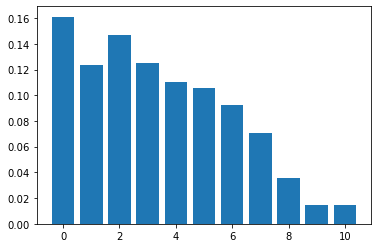

In [114]:
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_feature, y_feature)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## 5. MODELS

In [115]:
tfidf_vectorizer = TfidfVectorizer()
X_class = tfidf_vectorizer.fit_transform(data['lemmatized'])
y_class = data["label"]
X_class.shape

(10547, 12587)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)


Multinomial Naive Bayes - Original dataset

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2806
           1       0.37      0.25      0.30       359

    accuracy                           0.87      3165
   macro avg       0.64      0.60      0.61      3165
weighted avg       0.85      0.87      0.86      3165

0.8676145339652449


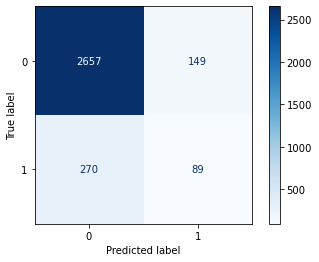

In [117]:
# Multinomial Naive Bayes
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_mnb = mnb.predict(X_test)
as_mnb = accuracy_score(y_test, y_mnb)
f1s_mnb = f1_score(y_test, y_mnb, average= "macro")
prec_mnb = precision_score(y_test, y_mnb)
rec_mnb = recall_score(y_test, y_mnb, average='macro')
print("\nMultinomial Naive Bayes - Original dataset\n")
plot_confusion_matrix(mnb, X_test,y_test, cmap= "Blues")
#print(confusion_matrix(y_test,y_mnb))
print(classification_report(y_test,y_mnb))
print(accuracy_score(y_test, y_mnb))

[LibSVM]
Support Vector Machine - Original dataset

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2806
           1       0.80      0.02      0.04       359

    accuracy                           0.89      3165
   macro avg       0.84      0.51      0.49      3165
weighted avg       0.88      0.89      0.84      3165

0.8884676145339653


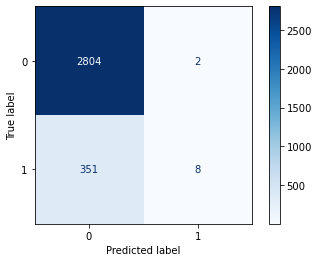

In [118]:
# Support Vector Machine
svc = SVC(verbose=10, random_state=42)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)
as_svc = accuracy_score(y_test, y_svc)
f1s_svc = f1_score(y_test, y_svc, average="macro")
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc, average='macro')
print("\nSupport Vector Machine - Original dataset\n")
plot_confusion_matrix(svc, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))


Logistic Regression - Original dataset

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2806
           1       0.76      0.04      0.07       359

    accuracy                           0.89      3165
   macro avg       0.83      0.52      0.51      3165
weighted avg       0.88      0.89      0.84      3165

0.8894154818325435


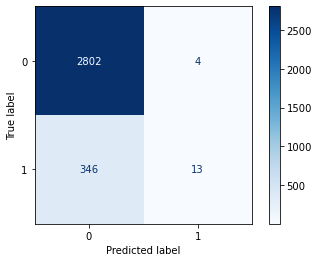

In [119]:
# Logistic
log_fit = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log = log_fit.predict(X_test)
as_log = accuracy_score(y_test, y_log)
f1s_log = f1_score(y_test, y_log, average= "macro")
prec_log = precision_score(y_test, y_log)
rec_log = recall_score(y_test, y_log, average='macro')
print("\nLogistic Regression - Original dataset\n")
plot_confusion_matrix(log_fit, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log))
print(classification_report(y_test,y_log))
print(accuracy_score(y_test, y_log))


Random Forest - Original dataset

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2806
           1       0.61      0.09      0.16       359

    accuracy                           0.89      3165
   macro avg       0.75      0.54      0.55      3165
weighted avg       0.86      0.89      0.85      3165

0.8903633491311217


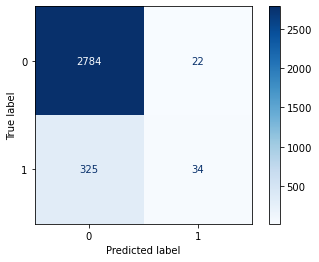

In [120]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train) 
y_rf = rf.predict(X_test)
as_rf = accuracy_score(y_test, y_rf)
f1s_rf = f1_score(y_test, y_rf, average= "macro")
prec_rf = precision_score(y_test, y_rf)
rec_rf = recall_score(y_test, y_rf, average='macro')
print("\nRandom Forest - Original dataset\n")
plot_confusion_matrix(rf, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf))
print(classification_report(y_test,y_rf))
print(accuracy_score(y_test, y_rf))


Decision Tree - Original dataset

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2806
           1       0.40      0.31      0.35       359

    accuracy                           0.87      3165
   macro avg       0.65      0.62      0.64      3165
weighted avg       0.85      0.87      0.86      3165

0.8682464454976303


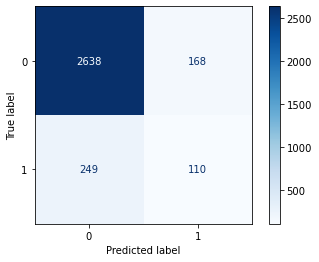

In [121]:
# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)
as_tree = accuracy_score(y_test, y_tree)
f1s_tree = f1_score(y_test, y_tree, average= "macro")
prec_tree = precision_score(y_test, y_tree)
rec_tree = recall_score(y_test, y_tree, average='macro')
print("\nDecision Tree - Original dataset\n")
plot_confusion_matrix(tree, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree))
print(classification_report(y_test,y_tree))
print(accuracy_score(y_test, y_tree))

In [122]:
s1 = pd.Series([as_mnb, as_svc, as_log, as_rf, as_tree], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s2 = pd.Series([f1s_mnb, f1s_svc, f1s_log, f1s_rf, f1s_tree], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s3 = pd.Series([prec_mnb, prec_svc, prec_log, prec_rf, prec_tree], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s4 = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_tree], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
d = {'Accuracy Score' : s1, 'Precision Score': s3, 'Recall Score' : s4, 'F1 Score' : s2 }
dfm = pd.DataFrame(d)
print("\nOriginal dataset\n")
dfm.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


Original dataset



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.867615,0.373950,0.597405,0.612536
Support Vector Machine,0.888468,0.800000,0.510786,0.492071
Logistic Regression,0.889415,0.764706,0.517393,0.505182
Random Forest,0.890363,0.607143,0.543434,0.552596
Decision Tree,0.868246,0.395683,0.623267,0.636061


### 5.1 Imbalanced

In [123]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

In [124]:
X_under, y_under = undersample.fit_resample(X_class, y_class)

In [125]:
print(Counter(y_under))

Counter({0: 1196, 1: 1196})


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42, stratify=y_under)


Multinomoial Naive Bayes - Balanced dataset

              precision    recall  f1-score   support

           0       0.73      0.60      0.66       359
           1       0.66      0.78      0.72       359

    accuracy                           0.69       718
   macro avg       0.70      0.69      0.69       718
weighted avg       0.70      0.69      0.69       718

0.6894150417827298


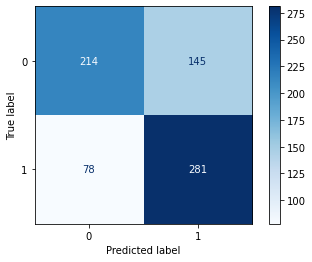

In [127]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print("\nMultinomoial Naive Bayes - Balanced dataset\n")
plot_confusion_matrix(mnb_i, X_test,y_test, cmap = "Blues")
#print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[LibSVM]
Support Vector Machine - Balanced dataset

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       359
           1       0.76      0.70      0.73       359

    accuracy                           0.74       718
   macro avg       0.74      0.74      0.74       718
weighted avg       0.74      0.74      0.74       718

0.7409470752089137


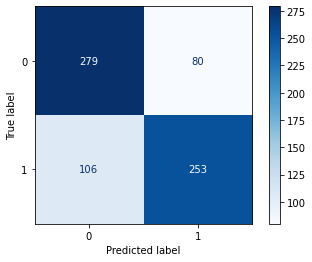

In [128]:
# Support Vector Machine
svc_i = SVC(verbose=10, random_state=42)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print("\nSupport Vector Machine - Balanced dataset\n")
plot_confusion_matrix(svc_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))


Logistic Regression - Balanced dataset

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       359
           1       0.74      0.71      0.73       359

    accuracy                           0.73       718
   macro avg       0.73      0.73      0.73       718
weighted avg       0.73      0.73      0.73       718

0.7325905292479109


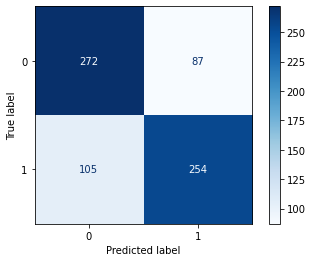

In [129]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print("\nLogistic Regression - Balanced dataset\n")
plot_confusion_matrix(log_fit_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))


Random Forest - Balanced dataset

              precision    recall  f1-score   support

           0       0.62      0.87      0.72       359
           1       0.78      0.47      0.58       359

    accuracy                           0.67       718
   macro avg       0.70      0.67      0.65       718
weighted avg       0.70      0.67      0.65       718

0.6657381615598886


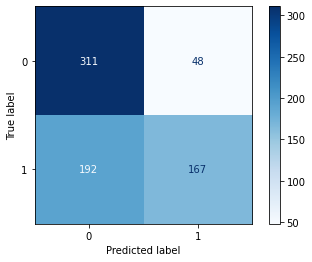

In [130]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print("\nRandom Forest - Balanced dataset\n")
plot_confusion_matrix(rf_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))


Decision Tree - Balanced dataset

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       359
           1       0.70      0.65      0.68       359

    accuracy                           0.69       718
   macro avg       0.69      0.69      0.69       718
weighted avg       0.69      0.69      0.69       718

0.6894150417827298


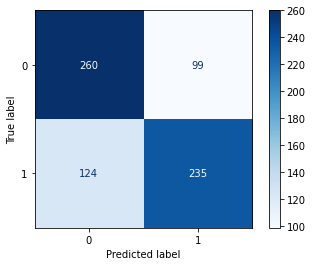

In [131]:
# Decision Tree
tree_i = DecisionTreeClassifier(random_state=42)
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print("\nDecision Tree - Balanced dataset\n")
plot_confusion_matrix(tree_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))

In [132]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_tree_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_tree_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_tree_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s4_i = pd.Series([rec_mnb_i, rec_svc_i, rec_log_i, rec_rf_i, rec_tree_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
print("\nBalanced dataset\n")
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


Balanced dataset



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.689415,0.659624,0.689415,0.686687
Support Vector Machine,0.740947,0.759760,0.740947,0.740607
Logistic Regression,0.732591,0.744868,0.732591,0.732422
Random Forest,0.665738,0.776744,0.665738,0.651730
Decision Tree,0.689415,0.703593,0.689415,0.689038


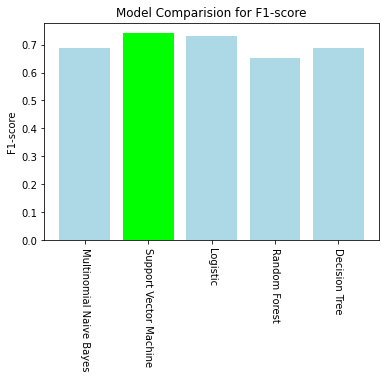

In [133]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(objects))
performance = [f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_tree_i]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('F1-score')
plt.title('Model Comparision for F1-score')
plt.show()

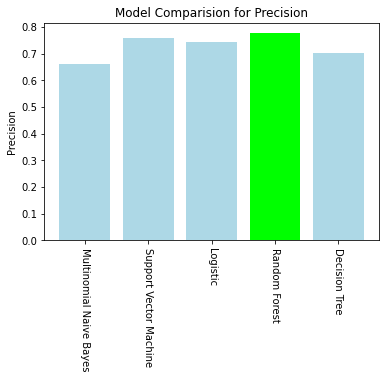

In [134]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(objects))
performance = [prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_tree_i]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('Precision')
plt.title('Model Comparision for Precision')
plt.show()

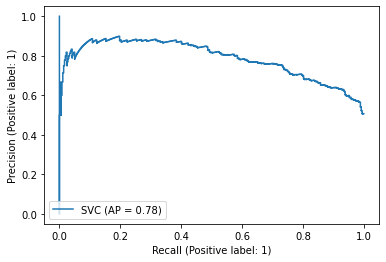

In [135]:
plot_precision_recall_curve(svc_i, X_test, y_test)

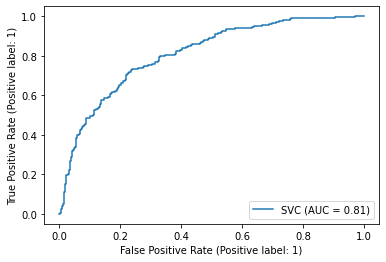

In [136]:
plot_roc_curve(svc_i,  X_test, y_test)

In [137]:
def hate_predict(X, vect, clf):
    lista_pulita = [full_text_clean(text) for text in X]
    X_new = vect.transform(lista_pulita)
    NO = clf.predict(X_new)
    return NO

In [138]:
lista = ['I hate you', 'I love black people', 'I love jew']

hate_predict(lista, tfidf_vectorizer, svc_i)

array([1, 1, 1], dtype=int64)

### 5.2 Models on POS

#### 5.2.1 Nouns + Proper Nouns + Adjectives + Adverbs

In [139]:
pos_list = ["NOUN" , "PROPN" ,"ADJ" ]

In [140]:
data["NOUN_PROPN_ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [141]:
tfidf_vectorizer = TfidfVectorizer()
X_Propn = tfidf_vectorizer.fit_transform(data["NOUN_PROPN_ADJ"])
y_Propn = data["label"]
X_Propn.shape

(10547, 12091)

In [142]:
X_over_p, y_over_p = undersample.fit_resample(X_Propn, y_Propn)

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X_over_p, y_over_p, test_size=0.3, random_state=42, stratify=y_over_p)


Multinomoial Naive Bayes - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       359
           1       0.68      0.75      0.71       359

    accuracy                           0.70       718
   macro avg       0.70      0.70      0.70       718
weighted avg       0.70      0.70      0.70       718

0.6991643454038997


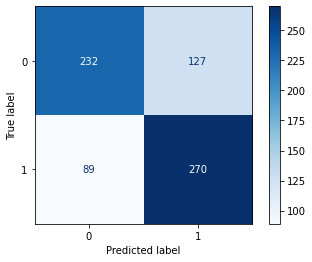

In [144]:
# Multinomial Naive Bayes
mnb_p = MultinomialNB(alpha=0.01)
mnb_p.fit(X_train, y_train)
y_mnb_p = mnb_p.predict(X_test)
as_mnb_p = accuracy_score(y_test, y_mnb_p)
f1s_mnb_p = f1_score(y_test, y_mnb_p, average= "macro")
prec_mnb_p = precision_score(y_test, y_mnb_p)
rec_mnb_p = recall_score(y_test, y_mnb_p, average='macro')
print("\nMultinomoial Naive Bayes - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(mnb_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_mnb_p))
print(classification_report(y_test,y_mnb_p))
print(accuracy_score(y_test, y_mnb_p))

[LibSVM]
Support Vector Machine - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       359
           1       0.76      0.67      0.71       359

    accuracy                           0.73       718
   macro avg       0.73      0.73      0.72       718
weighted avg       0.73      0.73      0.72       718

0.7256267409470752


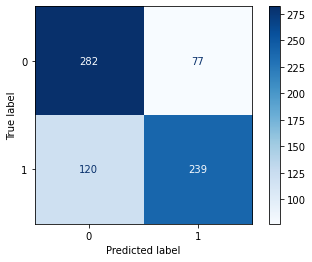

In [145]:
# Support Vector Machine
svc_p = SVC(verbose=10, random_state=42)
svc_p.fit(X_train, y_train)
y_svc_p = svc_p.predict(X_test)
as_svc_p = accuracy_score(y_test, y_svc_p)
f1s_svc_p = f1_score(y_test, y_svc_p, average="macro")
prec_svc_p = precision_score(y_test, y_svc_p)
rec_svc_p = recall_score(y_test, y_svc_p, average='macro')
print("\nSupport Vector Machine - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(svc_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_p))
print(classification_report(y_test,y_svc_p))
print(accuracy_score(y_test, y_svc_p))


Logistic Regression - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       359
           1       0.76      0.67      0.71       359

    accuracy                           0.73       718
   macro avg       0.73      0.73      0.73       718
weighted avg       0.73      0.73      0.73       718

0.7270194986072424


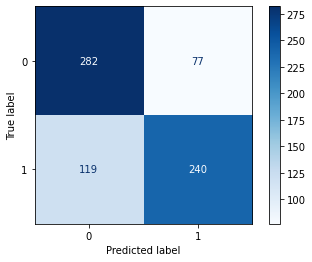

In [146]:
# Logistic
log_fit_p = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_p = log_fit_p.predict(X_test)
as_log_p = accuracy_score(y_test, y_log_p)
f1s_log_p = f1_score(y_test, y_log_p, average= "macro")
prec_log_p = precision_score(y_test, y_log_p)
rec_log_p = recall_score(y_test, y_log_p, average='macro')
print("\nLogistic Regression - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(log_fit_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_p))
print(classification_report(y_test,y_log_p))
print(accuracy_score(y_test, y_log_p))


Random Forest - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.62      0.85      0.72       359
           1       0.77      0.49      0.60       359

    accuracy                           0.67       718
   macro avg       0.70      0.67      0.66       718
weighted avg       0.70      0.67      0.66       718

0.66991643454039


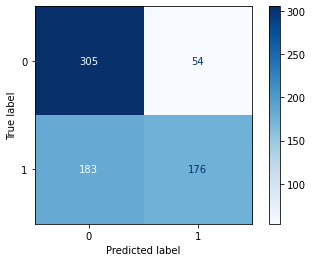

In [147]:
# Random Forest
rf_p = RandomForestClassifier(n_estimators=10, random_state=42)
rf_p.fit(X_train, y_train) 
y_rf_p = rf_p.predict(X_test)
as_rf_p = accuracy_score(y_test, y_rf_p)
f1s_rf_p = f1_score(y_test, y_rf_p, average= "macro")
prec_rf_p = precision_score(y_test, y_rf_p)
rec_rf_p = recall_score(y_test, y_rf_p, average='macro')
print("\nRandom Forest - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(rf_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_p))
print(classification_report(y_test,y_rf_p))
print(accuracy_score(y_test, y_rf_p))


Decision Tree - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.64      0.74      0.69       359
           1       0.69      0.59      0.64       359

    accuracy                           0.66       718
   macro avg       0.67      0.66      0.66       718
weighted avg       0.67      0.66      0.66       718

0.6629526462395543


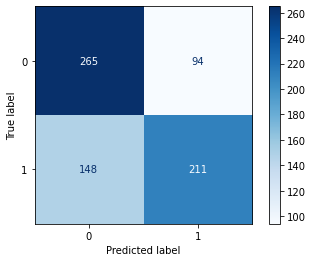

In [148]:
# Decision Tree
tree_p = DecisionTreeClassifier(random_state=42)
tree_p.fit(X_train, y_train)
y_tree_p = tree_p.predict(X_test)
as_tree_p = accuracy_score(y_test, y_tree_p)
f1s_tree_p = f1_score(y_test, y_tree_p, average= "macro")
prec_tree_p = precision_score(y_test, y_tree_p)
rec_tree_p = recall_score(y_test, y_tree_p, average='macro')
print("\nDecision Tree - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(tree_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_p))
print(classification_report(y_test,y_tree_p))
print(accuracy_score(y_test, y_tree_p))

In [149]:
s1_p = pd.Series([as_mnb_p, as_svc_p, as_log_p, as_rf_p, as_tree_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s2_p = pd.Series([f1s_mnb_p, f1s_svc_p, f1s_log_p, f1s_rf_p,  f1s_tree_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s3_p = pd.Series([prec_mnb_p, prec_svc_p, prec_log_p, prec_rf_p, prec_tree_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s4_p = pd.Series([rec_mnb_p, rec_svc_p, rec_log_p, rec_rf_p, rec_tree_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
d_p = {'Accuracy Score' : s1_p, 'Precision Score': s3_p, 'Recall Score' : s4_p, 'F1 Score' : s2_p}
dfm_p = pd.DataFrame(d_p)
print("\nNOUN_PROPN_ADJ\n")
dfm_p.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


NOUN_PROPN_ADJ



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.699164,0.680101,0.699164,0.698319
Support Vector Machine,0.725627,0.756329,0.725627,0.724639
Logistic Regression,0.727019,0.757098,0.727019,0.726082
Random Forest,0.669916,0.765217,0.669916,0.658906
Decision Tree,0.662953,0.691803,0.662953,0.661035


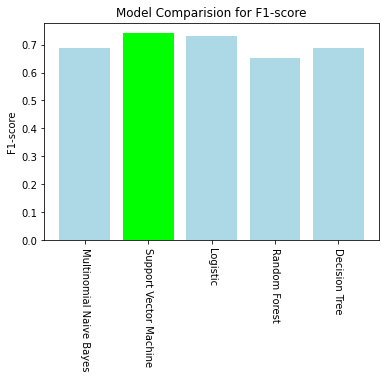

In [150]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(objects))
performance = [f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_tree_i]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center',  color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('F1-score')
plt.title('Model Comparision for F1-score')
plt.show()

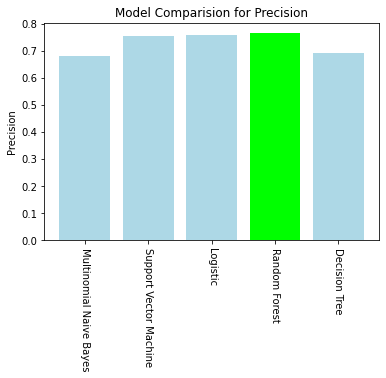

In [151]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(objects))
performance = [prec_mnb_p, prec_svc_p, prec_log_p, prec_rf_p, prec_tree_p]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('Precision')
plt.title('Model Comparision for Precision')
plt.show()

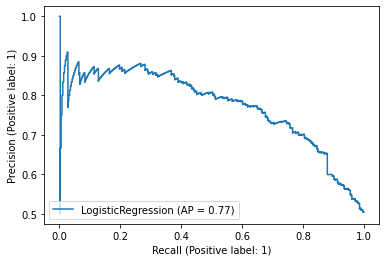

In [152]:
plot_precision_recall_curve(log_fit_p, X_test, y_test)

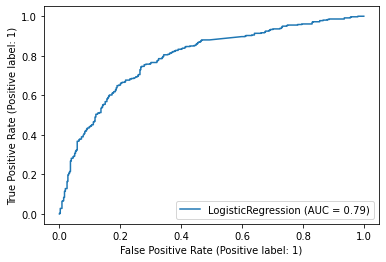

In [153]:
plot_roc_curve(log_fit_p,  X_test, y_test)

#### 5.2.2 Nouns + Proper Nouns + Verbs + Adjectives + Adverbs

In [154]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "DET"]

In [155]:
data["NOUN_PROPN_VERB_ADJ_ADV_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [156]:
tfidf_vectorizer = TfidfVectorizer()
X_NounPropnVerb = tfidf_vectorizer.fit_transform(data["NOUN_PROPN_VERB_ADJ_ADV_DET"])
y_NounPropnVerb = data["label"]
X_NounPropnVerb.shape

(10547, 14596)

In [157]:
X_over_n, y_over_n = undersample.fit_resample(X_NounPropnVerb, y_NounPropnVerb)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_over_n, y_over_n, test_size=0.3, random_state=42, stratify=y_over_n)


Multinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.71      0.58      0.64       359
           1       0.64      0.76      0.70       359

    accuracy                           0.67       718
   macro avg       0.68      0.67      0.67       718
weighted avg       0.68      0.67      0.67       718

0.66991643454039


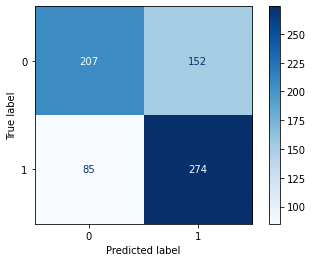

In [159]:
# Multinomial Naive Bayes
mnb_n = MultinomialNB(alpha=0.01)
mnb_n.fit(X_train, y_train)
y_mnb_n = mnb_n.predict(X_test)
as_mnb_n = accuracy_score(y_test, y_mnb_n)
f1s_mnb_n = f1_score(y_test, y_mnb_n, average= "macro")
prec_mnb_n = precision_score(y_test, y_mnb_n)
rec_mnb_n = recall_score(y_test, y_mnb_n, average='macro')
print("\nMultinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(mnb_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_mnb_n))
print(classification_report(y_test,y_mnb_n))
print(accuracy_score(y_test, y_mnb_n))

[LibSVM]
Support Vector Machine - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       359
           1       0.73      0.67      0.70       359

    accuracy                           0.71       718
   macro avg       0.71      0.71      0.71       718
weighted avg       0.71      0.71      0.71       718

0.713091922005571


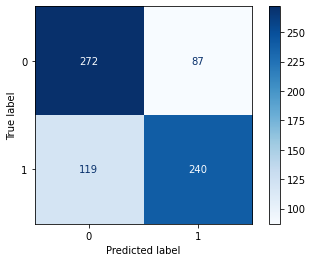

In [160]:
# Support Vector Machine
svc_n = SVC(verbose=10, random_state=42)
svc_n.fit(X_train, y_train)
y_svc_n = svc_n.predict(X_test)
as_svc_n = accuracy_score(y_test, y_svc_n)
f1s_svc_n = f1_score(y_test, y_svc_n, average="macro")
prec_svc_n = precision_score(y_test, y_svc_n)
rec_svc_n = recall_score(y_test, y_svc_n, average='macro')
print("\nSupport Vector Machine - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(svc_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_n)
print(classification_report(y_test,y_svc_n))
print(accuracy_score(y_test, y_svc_n))


Logistic Regression - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.69      0.74      0.72       359
           1       0.72      0.67      0.70       359

    accuracy                           0.71       718
   macro avg       0.71      0.71      0.71       718
weighted avg       0.71      0.71      0.71       718

0.7061281337047354


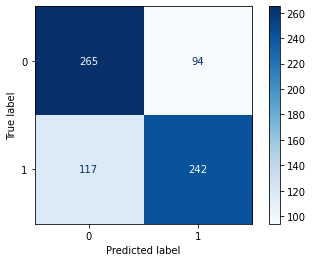

In [161]:
# Logistic
log_fit_n = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_n = log_fit_n.predict(X_test)
as_log_n = accuracy_score(y_test, y_log_n)
f1s_log_n = f1_score(y_test, y_log_n, average= "macro")
prec_log_n = precision_score(y_test, y_log_n)
rec_log_n = recall_score(y_test, y_log_n, average='macro')
print("\nLogistic Regression - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(log_fit_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_n))
print(classification_report(y_test,y_log_n))
print(accuracy_score(y_test, y_log_n))


Random Forest - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.64      0.81      0.71       359
           1       0.74      0.53      0.62       359

    accuracy                           0.67       718
   macro avg       0.69      0.67      0.67       718
weighted avg       0.69      0.67      0.67       718

0.6727019498607242


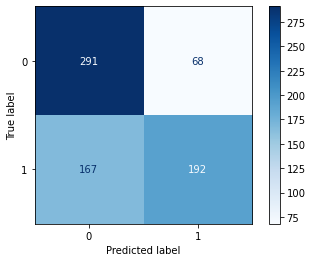

In [162]:
# Random Forest
rf_n = RandomForestClassifier(n_estimators=10, random_state=42)
rf_n.fit(X_train, y_train) 
y_rf_n = rf_n.predict(X_test)
as_rf_n = accuracy_score(y_test, y_rf_n)
f1s_rf_n = f1_score(y_test, y_rf_n, average= "macro")
prec_rf_n = precision_score(y_test, y_rf_n)
rec_rf_n = recall_score(y_test, y_rf_n, average='macro')
print("\nRandom Forest - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(rf_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_n))
print(classification_report(y_test,y_rf_n))
print(accuracy_score(y_test, y_rf_n))


Decision Tree - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       359
           1       0.72      0.62      0.67       359

    accuracy                           0.69       718
   macro avg       0.69      0.69      0.69       718
weighted avg       0.69      0.69      0.69       718

0.6894150417827298


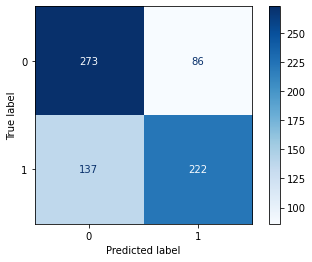

In [163]:
# Decision Tree
tree_n = DecisionTreeClassifier(random_state=42)
tree_n.fit(X_train, y_train)
y_tree_n = tree_n.predict(X_test)
as_tree_n = accuracy_score(y_test, y_tree_n)
f1s_tree_n = f1_score(y_test, y_tree_n, average= "macro")
prec_tree_n = precision_score(y_test, y_tree_n)
rec_tree_n = recall_score(y_test, y_tree_n, average='macro')
print("\nDecision Tree - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(tree_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_n))
print(classification_report(y_test,y_tree_n))
print(accuracy_score(y_test, y_tree_n))

In [164]:
s1_n = pd.Series([as_mnb_n, as_svc_n, as_log_n, as_rf_n, as_tree_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s2_n = pd.Series([f1s_mnb_n, f1s_svc_n, f1s_log_n, f1s_rf_n, f1s_tree_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s3_n = pd.Series([prec_mnb_n, prec_svc_n, prec_log_n, prec_rf_n, prec_tree_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s4_n = pd.Series([rec_mnb_n, rec_svc_n, rec_log_n, rec_rf_n, rec_tree_n,], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
d_n = {'Accuracy Score' : s1_n, 'Precision Score': s3_n, 'Recall Score' : s4_n, 'F1 Score' : s2_n}
dfm_n = pd.DataFrame(d_n)
print("\nNOUN_PROPN_VERB_ADJ_ADV_DET\n")
dfm_n.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


NOUN_PROPN_VERB_ADJ_ADV_DET



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.669916,0.643192,0.669916,0.667017
Support Vector Machine,0.713092,0.733945,0.713092,0.712521
Logistic Regression,0.706128,0.720238,0.706128,0.705826
Random Forest,0.672702,0.738462,0.672702,0.666359
Decision Tree,0.689415,0.720779,0.689415,0.687840


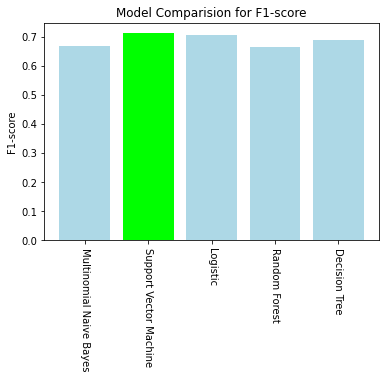

In [165]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(objects))
performance = [f1s_mnb_n, f1s_svc_n, f1s_log_n, f1s_rf_n, f1s_tree_n]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('F1-score')
plt.title('Model Comparision for F1-score')
plt.show()

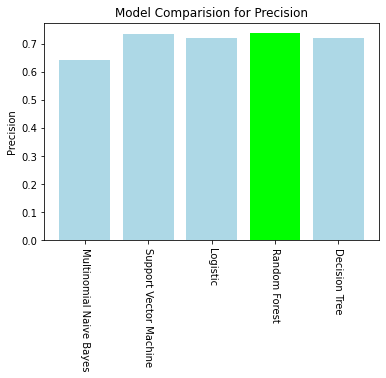

In [166]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(objects))
performance = [prec_mnb_n, prec_svc_n, prec_log_n, prec_rf_n, prec_tree_n]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('Precision')
plt.title('Model Comparision for Precision')
plt.show()

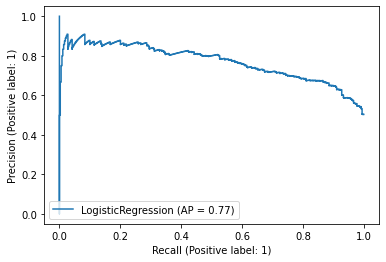

In [167]:
plot_precision_recall_curve(log_fit_n, X_test, y_test)

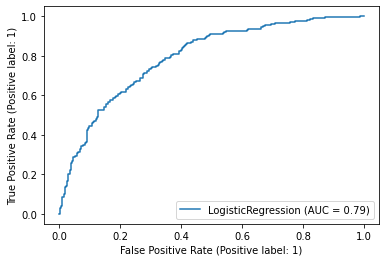

In [168]:
plot_roc_curve(log_fit_n,  X_test, y_test)

## MODEL USING POLARITY AS FEATURE

In [169]:
sentiment_analyzer = VS()
def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    features = [sentiment['neu'], sentiment['neg']]
    #features = pandas.DataFrame(features)
    return features

In [170]:
def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

In [171]:
final_features = sentiment_analysis_array(data["text_clean"])

In [172]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_features_scaled = scaler.fit_transform(final_features)

In [173]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_npvaad = tfidf_vectorizer.fit_transform(data["text_clean"])
tfidf_a = tfidf_npvaad.toarray()
modelling_features = np.concatenate([tfidf_a,final_features_scaled],axis=1)
modelling_features.shape

(10547, 14774)

In [174]:
X_f = pd.DataFrame(modelling_features)
y_f = data["label"]
X, y = undersample.fit_resample(X_f, y_f)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y, random_state=42, test_size=0.2)


Multinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.74      0.64      0.68       236
           1       0.69      0.79      0.73       243

    accuracy                           0.71       479
   macro avg       0.72      0.71      0.71       479
weighted avg       0.72      0.71      0.71       479

0.7118997912317327


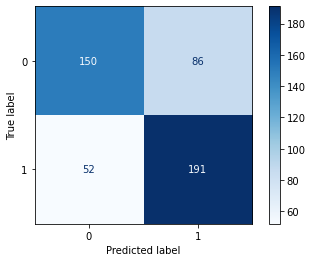

In [175]:
# Multinomial Naive Bayes
mnb_f = MultinomialNB(alpha=0.01)
mnb_f.fit(X_train_f, y_train_f)
y_mnb_f = mnb_f.predict(X_test_f)
as_mnb_f = accuracy_score(y_test_f, y_mnb_f)
f1s_mnb_f = f1_score(y_test_f, y_mnb_f, average= "macro")
prec_mnb_f = precision_score(y_test_f, y_mnb_f)
rec_mnb_f = recall_score(y_test_f, y_mnb_f, average='macro')
print("\nMultinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(mnb_f, X_test_f,y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_mnb_f))
print(classification_report(y_test_f,y_mnb_f))
print(accuracy_score(y_test_f, y_mnb_f))

[LibSVM]
Support Vector Machine - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       236
           1       0.78      0.70      0.74       243

    accuracy                           0.75       479
   macro avg       0.75      0.75      0.75       479
weighted avg       0.75      0.75      0.75       479

0.7473903966597077


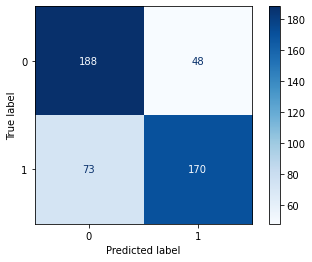

In [176]:
# Support Vector Machine
svc_f = SVC(verbose=10, random_state=42)
svc_f.fit(X_train_f, y_train_f)
y_svc_f = svc_f.predict(X_test_f)
as_svc_f = accuracy_score(y_test_f, y_svc_f)
f1s_svc_f = f1_score(y_test_f, y_svc_f, average="macro")
prec_svc_f = precision_score(y_test_f, y_svc_f)
rec_svc_f = recall_score(y_test_f, y_svc_f, average='macro')
print("\nSupport Vector Machine - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(svc_f, X_test_f,y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_svc_f)
print(classification_report(y_test_f,y_svc_f))
print(accuracy_score(y_test_f, y_svc_f))


Logistic Regression - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       236
           1       0.82      0.73      0.77       243

    accuracy                           0.78       479
   macro avg       0.78      0.78      0.78       479
weighted avg       0.78      0.78      0.78       479

0.778705636743215


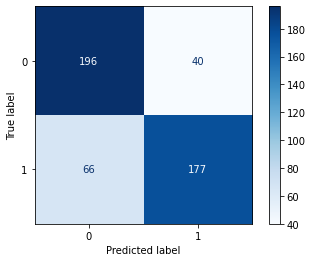

In [177]:
# Logistic
log_fit_f = LogisticRegression(random_state=42).fit(X_train_f, y_train_f)
y_log_f = log_fit_f.predict(X_test_f)
as_log_f = accuracy_score(y_test_f, y_log_f)
f1s_log_f = f1_score(y_test_f, y_log_f, average= "macro")
prec_log_f = precision_score(y_test_f, y_log_f)
rec_log_f = recall_score(y_test_f, y_log_f, average='macro')
print("\nLogistic Regression - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(log_fit_f, X_test_f,y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_log_f))
print(classification_report(y_test_f,y_log_f))
print(accuracy_score(y_test_f, y_log_f))


Random Forest - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       236
           1       0.78      0.56      0.65       243

    accuracy                           0.70       479
   macro avg       0.71      0.70      0.69       479
weighted avg       0.71      0.70      0.69       479

0.6951983298538622


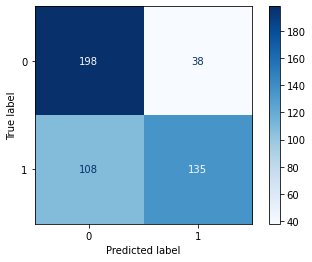

In [178]:
# Random Forest
rf_f = RandomForestClassifier(n_estimators=10, random_state=42)
rf_f.fit(X_train_f, y_train_f) 
y_rf_f = rf_f.predict(X_test_f)
as_rf_f = accuracy_score(y_test_f, y_rf_f)
f1s_rf_f = f1_score(y_test_f, y_rf_f, average= "macro")
prec_rf_f = precision_score(y_test_f,y_rf_f)
rec_rf_f = recall_score(y_test_f, y_rf_f, average='macro')
print("\nRandom Forest - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(rf_f, X_test_f ,y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_rf_f))
print(classification_report(y_test_f ,y_rf_f))
print(accuracy_score(y_test_f, y_rf_f))


Decision Tree - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       236
           1       0.68      0.67      0.67       243

    accuracy                           0.67       479
   macro avg       0.67      0.67      0.67       479
weighted avg       0.67      0.67      0.67       479

0.6722338204592901


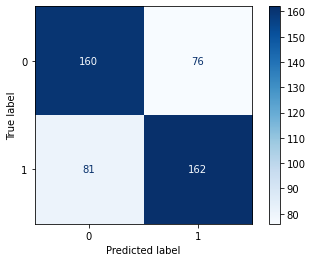

In [179]:
# Decision Tree
tree_f = DecisionTreeClassifier(random_state=42)
tree_f.fit(X_train_f, y_train_f)
y_tree_f = tree_f.predict(X_test_f)
as_tree_f = accuracy_score(y_test_f, y_tree_f)
f1s_tree_f = f1_score(y_test_f, y_tree_f, average= "macro")
prec_tree_f = precision_score(y_test_f, y_tree_f)
rec_tree_f = recall_score(y_test_f, y_tree_f, average='macro')
print("\nDecision Tree - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(tree_f, X_test_f, y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_tree_f))
print(classification_report(y_test_f,y_tree_f))
print(accuracy_score(y_test_f, y_tree_f))

In [180]:
s1_f = pd.Series([as_mnb_f, as_svc_f, as_log_f, as_rf_f, as_tree_f], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s2_f = pd.Series([f1s_mnb_f, f1s_svc_f, f1s_log_f, f1s_rf_f,  f1s_tree_f], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s3_f = pd.Series([prec_mnb_f, prec_svc_f, prec_log_f, prec_rf_f, prec_tree_f], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
s4_f = pd.Series([rec_mnb_f, rec_svc_f, rec_log_f, rec_rf_f, rec_tree_f], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Decision Tree'])
d_f = {'Accuracy Score' : s1_f, 'Precision Score': s3_f, 'Recall Score' : s4_f, 'F1 Score' : s2_f}
dfm_f = pd.DataFrame(d_f)
print("\nNOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
dfm_f.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.711900,0.689531,0.710801,0.709773
Support Vector Machine,0.747390,0.779817,0.748099,0.747033
Logistic Regression,0.778706,0.815668,0.779452,0.778357
Random Forest,0.695198,0.780347,0.697269,0.689833
Decision Tree,0.672234,0.680672,0.672316,0.672228


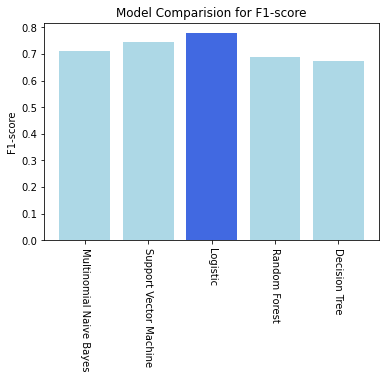

In [181]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(objects))
performance = [f1s_mnb_f, f1s_svc_f, f1s_log_f, f1s_rf_f, f1s_tree_f]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('F1-score')
plt.title('Model Comparision for F1-score')
plt.show()

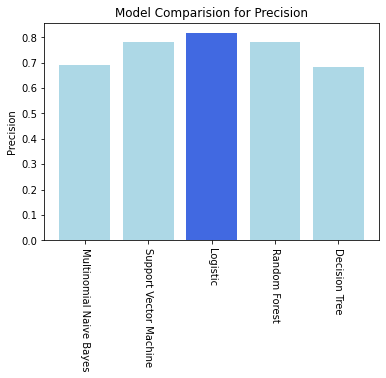

In [182]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(objects))
performance = [prec_mnb_f, prec_svc_f, prec_log_f, prec_rf_f, prec_tree_f]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('Precision')
plt.title('Model Comparision for Precision')
plt.show()

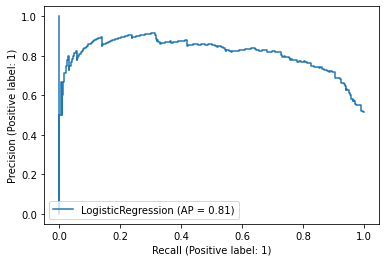

In [183]:
plot_precision_recall_curve(log_fit_f, X_test_f, y_test_f)

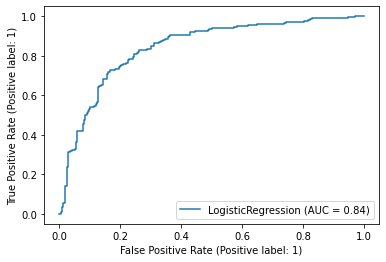

In [184]:
plot_roc_curve(log_fit_f,  X_test_f, y_test_f)

### Sentiment Analysis by nltk VEDER 

In [186]:
sia = vd.SentimentIntensityAnalyzer()
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV",  "DET" ]
data["NOUN_PROPN_VERB_ADJ_ADV_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPVAAD'] = data["NOUN_PROPN_VERB_ADJ_ADV_DET"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPVAAD']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.12763169150793346


In [185]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP", "DET" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPVAAAD'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP_DET"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPVAAAD']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.12760108106479087


In [187]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPVAAA'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPVAAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.1273331463514497


In [188]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV" ]
data["NOUN_PROPN_VERB_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPAA'] = data["NOUN_PROPN_VERB_ADJ_ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.12736367189686024


In [189]:
pos_list = ["NOUN","PROPN", "ADJ" ]
data["NOUN_PROPN_ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPAA'] = data["NOUN_PROPN_ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.11894934517002292


In [190]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "SCONJ"]
data["NOUN_PROPN_VERB_ADJ_ADV_SCONJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPAA'] = data["NOUN_PROPN_VERB_ADJ_ADV_SCONJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.11945115749361902


In [191]:
data['sentiment_text'] = data["lemmatized"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_text']
correl_text = col1.corr(col2)
print(correl_text)

-0.12115018375175138


In [192]:
pos_list = ["NOUN","PROPN", "ADJ", "ADV" ]
data["NOUN_PROPN_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPAA'] = data["NOUN_PROPN_ADJ_ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.11444306601924162


In [193]:
data['sentiment_ADJ'] = data["ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADJ']
correl_ADJ = col1.corr(col2)
print(correl_ADJ)

-0.08853693361981153


In [194]:
data['sentiment_NOUN'] = data["NOUN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN']
correl_NOUN = col1.corr(col2)
print(correl_NOUN)

-0.08167327198672972


In [195]:
data['sentiment_VERB'] = data["VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_VERB']
correl_VERB = col1.corr(col2)
print(correl_VERB)

-0.06862584995049852


In [196]:
data['sentiment_PROPN'] = data["PROPN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PROPN']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.04022955632477127


In [197]:
pos_list = ["ADP"]
data["ADP"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_ADP'] = data["ADP"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADP']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.0010373130255039525


In [198]:
data['sentiment_PRON'] = data["PRON"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PRON']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.0034825124510138037


In [199]:
data['sentiment_ADV'] = data["ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADV']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

0.0024356631486092506


In [200]:
data['sentiment_SCONJ'] = data["SCONJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_SCONJ']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

0.03766045468556142


### Polarity by TextBlob

Text(0, 0.5, 'Number of texts')

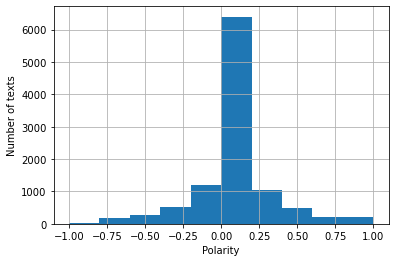

In [201]:
data['polarity'] = data['lemmatized'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity'].unique()
data['polarity'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of texts")

Text(0, 0.5, 'Number of NPAA')

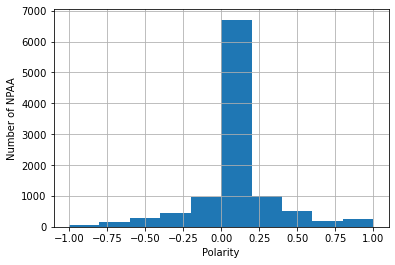

In [202]:
data['polarity_NPAA'] = data["NOUN_PROPN_ADJ_ADV"].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NPAA'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of NPAA")

Text(0, 0.5, 'Number of NPVAASA')

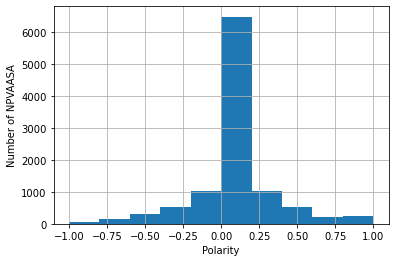

In [203]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP", "SCONJ" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP_SCONJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['polarity_NPVAASA'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP_SCONJ"].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NPVAASA'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of NPVAASA")

Text(0, 0.5, 'Number of NPVAAA')

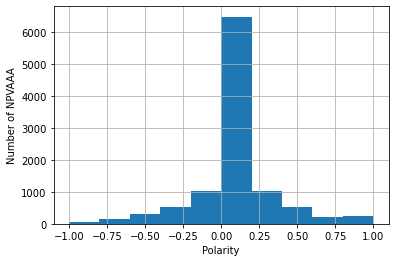

In [204]:
data['polarity_NPVAAA'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP"].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NPVAAA'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of NPVAAA")

Text(0, 0.5, 'Number of Adjectives')

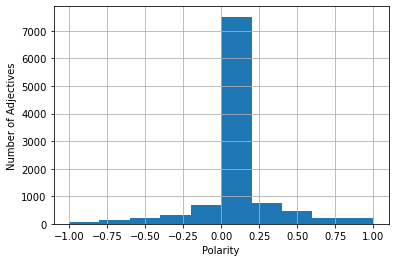

In [205]:
data['polarity_ADJ'] = data['ADJ'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_ADJ'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Adjectives")

Text(0, 0.5, 'Number of Nouns')

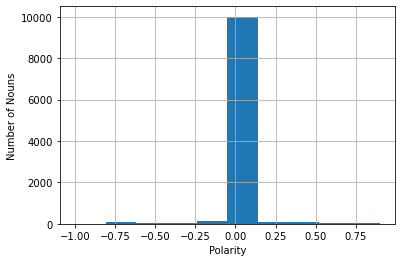

In [206]:
data['polarity_NOUN'] = data['NOUN'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NOUN'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Nouns")

Text(0, 0.5, 'Number of Proper Nouns')

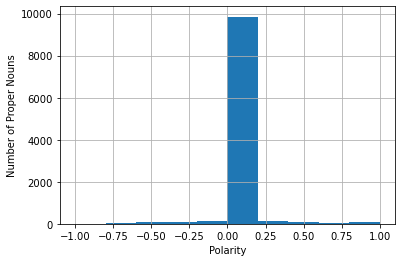

In [207]:
data['polarity_PROPN'] = data['PROPN'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_PROPN'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Proper Nouns")

Text(0, 0.5, 'Number of Verbs')

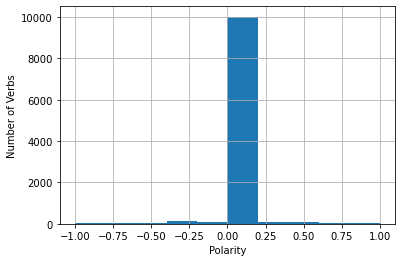

In [208]:
data['polarity_VERB'] = data['VERB'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_VERB'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Verbs")

Text(0, 0.5, 'Number of Adverbs')

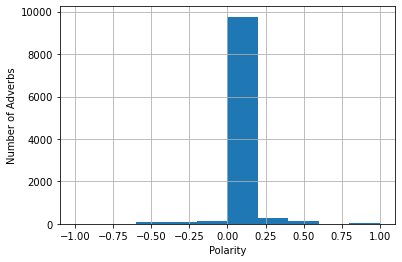

In [209]:
data['polarity_ADV'] = data['ADV'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_ADV'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Adverbs")

Text(0, 0.5, 'Number of Adposition')

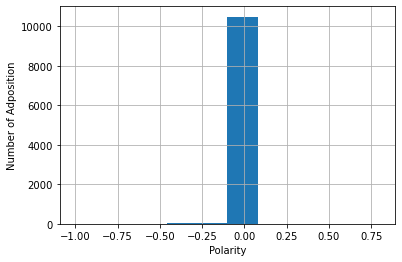

In [210]:
data['polarity_ADP'] = data['ADP'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_ADP'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Adposition")

Text(0, 0.5, 'Number of Pronouns')

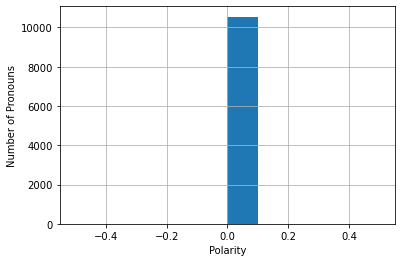

In [211]:
data['polarity_PRON'] = data['PRON'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_PRON'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Pronouns")

Text(0, 0.5, 'Number of Subordinating Conjunctions')

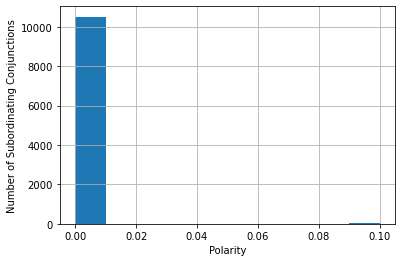

In [212]:
data['polarity_SCONJ'] = data['SCONJ'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_SCONJ'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Subordinating Conjunctions")

Text(0, 0.5, 'Number of Interjection')

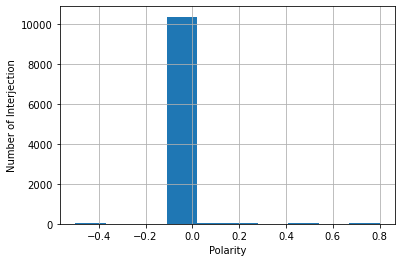

In [213]:
data['polarity_INTJ'] = data['INTJ'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_INTJ'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Interjection")

## Save the `data` df created so far

In [214]:
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

#### Check for punctuation (POS=PUNCT)

In [215]:
pos_list = ["PUNCT"]
data["PUNCT"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data[data['PUNCT'].str.contains(".")].head()

,label,text,text_clean,word_count_before,word_count,word_cleaning,spacy_doc,POS_spacy,lemmatized,tokens,...,polarity_ADJ,polarity_NOUN,polarity_PROPN,polarity_VERB,polarity_ADV,polarity_ADP,polarity_PRON,polarity_SCONJ,polarity_INTJ,PUNCT
124,0,OK I have been through some of the other threa...,ok threads section ns watched videos yt,23,7,16,"(ok, threads, section, ns, watched, videos, yt)","[(ok, INTJ), (threads, PROPN), (section, NOUN)...",ok threads section ns watch video yt,"[ok, threads, section, ns, watched, videos, yt]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,yt
752,0,I will be handing all mine over to the proper ...,handing mine proper authorities,12,4,8,"(handing, mine, proper, authorities)","[(handing, VERB), (mine, PUNCT), (proper, ADJ)...",hand mine proper authority,"[handing, mine, proper, authorities]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mine
1184,0,I bet all the Ted Pike stuff is on the ADL hit...,bet ted pike stuff adl hit list look start dis...,24,12,12,"(bet, ted, pike, stuff, adl, hit, list, look, ...","[(bet, PROPN), (ted, PROPN), (pike, PROPN), (s...",bet ted pike stuff adl hit list look start dis...,"[bet, ted, pike, stuff, adl, hit, list, look, ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,adl
1495,0,The French N.B communities near Quebec especia...,french nb communities near quebec especially w...,12,8,4,"(french, nb, communities, near, quebec, especi...","[(french, ADJ), (nb, PROPN), (communities, NOU...",french nb community near quebec especially wou...,"[french, nb, communities, near, quebec, especi...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,white
1954,0,I told him how to go and then said you ar no...,told go said ar around ya lol,19,7,12,"(told, go, said, ar, around, ya, lol)","[(told, VERB), (go, PROPN), (said, VERB), (ar,...",tell go say ar around ya lol,"[told, go, said, ar, around, ya, lol]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lol


In [216]:
pos_list = ["X"]
data["X_POS"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data[data['X_POS'].str.contains(".")]

,label,text,text_clean,word_count_before,word_count,word_cleaning,spacy_doc,POS_spacy,lemmatized,tokens,...,polarity_NOUN,polarity_PROPN,polarity_VERB,polarity_ADV,polarity_ADP,polarity_PRON,polarity_SCONJ,polarity_INTJ,PUNCT,X_POS
5,0,Booklet updated on Feb. 14th 2014 .,booklet updated feb th,7,4,3,"(booklet, updated, feb, th)","[(booklet, PROPN), (updated, VERB), (feb, PROP...",booklet update feb th,"[booklet, updated, feb, th]",...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,,th
107,0,Obama has membership in Prince Hall ( for blac...,obama membership prince hall blacks lodge beco...,36,16,20,"(obama, membership, prince, hall, blacks, lodg...","[(obama, PROPN), (membership, NOUN), (prince, ...",obama membership prince hall black lodge becom...,"[obama, membership, prince, hall, blacks, lodg...",...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,,youtube
143,0,BTW - I do not recall seeing a Mars Bar in S.A ?,btw recall seeing mars bar sa,13,6,7,"(btw, recall, seeing, mars, bar, sa)","[(btw, ADV), (recall, VERB), (seeing, VERB), (...",btw recall see mars bar sa,"[btw, recall, seeing, mars, bar, sa]",...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,,sa
459,0,: P + from someone else to Csabi : `` So accor...,p someone else csabi according csabi romanians...,20,10,10,"(p, someone, else, csabi, according, csabi, ro...","[(p, X), (someone, PRON), (else, ADV), (csabi,...",p someone else csabi accord csabi romanians li...,"[p, someone, else, csabi, according, csabi, ro...",...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,,p
537,0,im 27 live in manchvagas n.h. my x girl was su...,im live manchvagas nh x girl suposed go broke ...,45,24,21,"(i, m, live, manchvagas, nh, x, girl, suposed,...","[(i, PRON), (m, VERB), (live, VERB), (manchvag...",-PRON- be live manchvagas nh x girl supose go ...,"[i, m, live, manchvagas, nh, x, girl, suposed,...",...,0.0,0.0,0.136364,0.0,0.0,0.0,0.0,0.0,,hammerfistcom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10734,0,I forgot .,forgot,3,1,2,(forgot),"[(forgot, X)]",forgot,[forgot],...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,,forgot
10736,0,Viva la MayheeKo !,viva la mayheeko,4,3,1,"(viva, la, mayheeko)","[(viva, X), (la, PROPN), (mayheeko, PROPN)]",viva la mayheeko,"[viva, la, mayheeko]",...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,,viva
10740,0,If a white person wants to do well at any kind...,white person wants well kind academic subject ...,42,21,21,"(white, person, wants, well, kind, academic, s...","[(white, ADJ), (person, NOUN), (wants, VERB), ...",white person want well kind academic subject l...,"[white, person, wants, well, kind, academic, s...",...,0.5,0.0,0.200000,0.3,0.0,0.0,0.0,0.0,,etc etc
10783,0,Q : If Timmy can hop a distance of 2 feet and ...,q timmy hop distance feet makes hops far hop s...,30,13,17,"(q, timmy, hop, distance, feet, makes, hops, f...","[(q, X), (timmy, PROPN), (hop, PROPN), (distan...",q timmy hop distance foot make hop far hop sta...,"[q, timmy, hop, distance, feet, makes, hops, f...",...,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,,q


# N-grams

### Bi-grams

In [217]:
bi = [list(nltk.bigrams(x)) for x in data['tokens']]

In [218]:
lista = []
for x in bi:
    if x not in lista:
        lista.append(x)

In [219]:
bi_count = {}
for item in lista:
    for x in item:
        if x in bi_count:
            bi_count[x] +=1
        else:
            bi_count[x] = 1

In [220]:
top_bi = {k: v for k, v in sorted(bi_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_bi

{('i', 'm'): 239,
 ('do', 'nt'): 156,
 ('i', 've'): 74,
 ('personal', 'message'): 73,
 ('white', 'people'): 68,
 ('would', 'like'): 60,
 ('that', 's'): 58,
 ('years', 'ago'): 52,
 ('white', 'nationalist'): 48,
 ('ca', 'nt'): 48,
 ('year', 'old'): 44,
 ('looks', 'like'): 44,
 ('i', 'd'): 41,
 ('can', 'not'): 37,
 ('high', 'school'): 37,
 ('white', 'race'): 34,
 ('new', 'york'): 32,
 ('white', 'man'): 28,
 ('south', 'africa'): 28,
 ('one', 'day'): 27}

### Tri-grams

In [221]:
tri = [list(nltk.trigrams(x)) for x in data['tokens']]

In [222]:
lista_tri = []
for x in tri:
    if x not in lista_tri:
        lista_tri.append(x)

In [223]:
tri_count = {}
for item in lista_tri:
    for x in item:
        if x in tri_count:
            tri_count[x] +=1
        else:
            tri_count[x] = 1

In [224]:
top_tri = {k: v for k, v in sorted(tri_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_tri

{('do', 'nt', 'know'): 19,
 ('i', 'm', 'sure'): 17,
 ('i', 'm', 'looking'): 15,
 ('i', 'm', 'glad'): 13,
 ('i', 've', 'seen'): 11,
 ('i', 'm', 'going'): 11,
 ('i', 've', 'never'): 10,
 ('send', 'personal', 'message'): 10,
 ('i', 'd', 'like'): 10,
 ('do', 'nt', 'even'): 9,
 ('do', 'nt', 'want'): 9,
 ('new', 'york', 'city'): 8,
 ('dr', 'william', 'pierce'): 8,
 ('hair', 'blue', 'eyes'): 7,
 ('i', 'm', 'new'): 7,
 ('like', 'minded', 'people'): 7,
 ('ku', 'klux', 'klan'): 7,
 ('would', 'like', 'say'): 7,
 ('do', 'nt', 'get'): 6,
 ('i', 'd', 'say'): 6}